In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

In [18]:
# Import csv to be plotted
df_plots = pd.read_csv('../data/cleaned_data/us_accidents_cleaned.csv')

In [19]:
# Check preview of data
df_plots.head(1)

,severity,start_lat,start_lng,description,city,county,state,temperature(f),humidity(%),visibility(mi),...,precipitation(in),weather_condition,crossing,junction,traffic_signal,sunrise_sunset,year,month,day,time
0,2,37.530804,-122.297714,Accident on 39th Ave at Edison St.,San Mateo,San Mateo,CA,69.8,56.0,9.0,...,0.0,Clear,False,False,False,Day,2016,July,1,13:17:37


# 1.1 Correlation heatmap
To understand the relationship between numerical variables, we calculate the Pearson correlation coefficient. We then visualise this using a heatmap to identify patterns:
Values close to 1 and -1 have a strong relationship whereas the closer to 0 the lower the relationship and everything is down to chance.

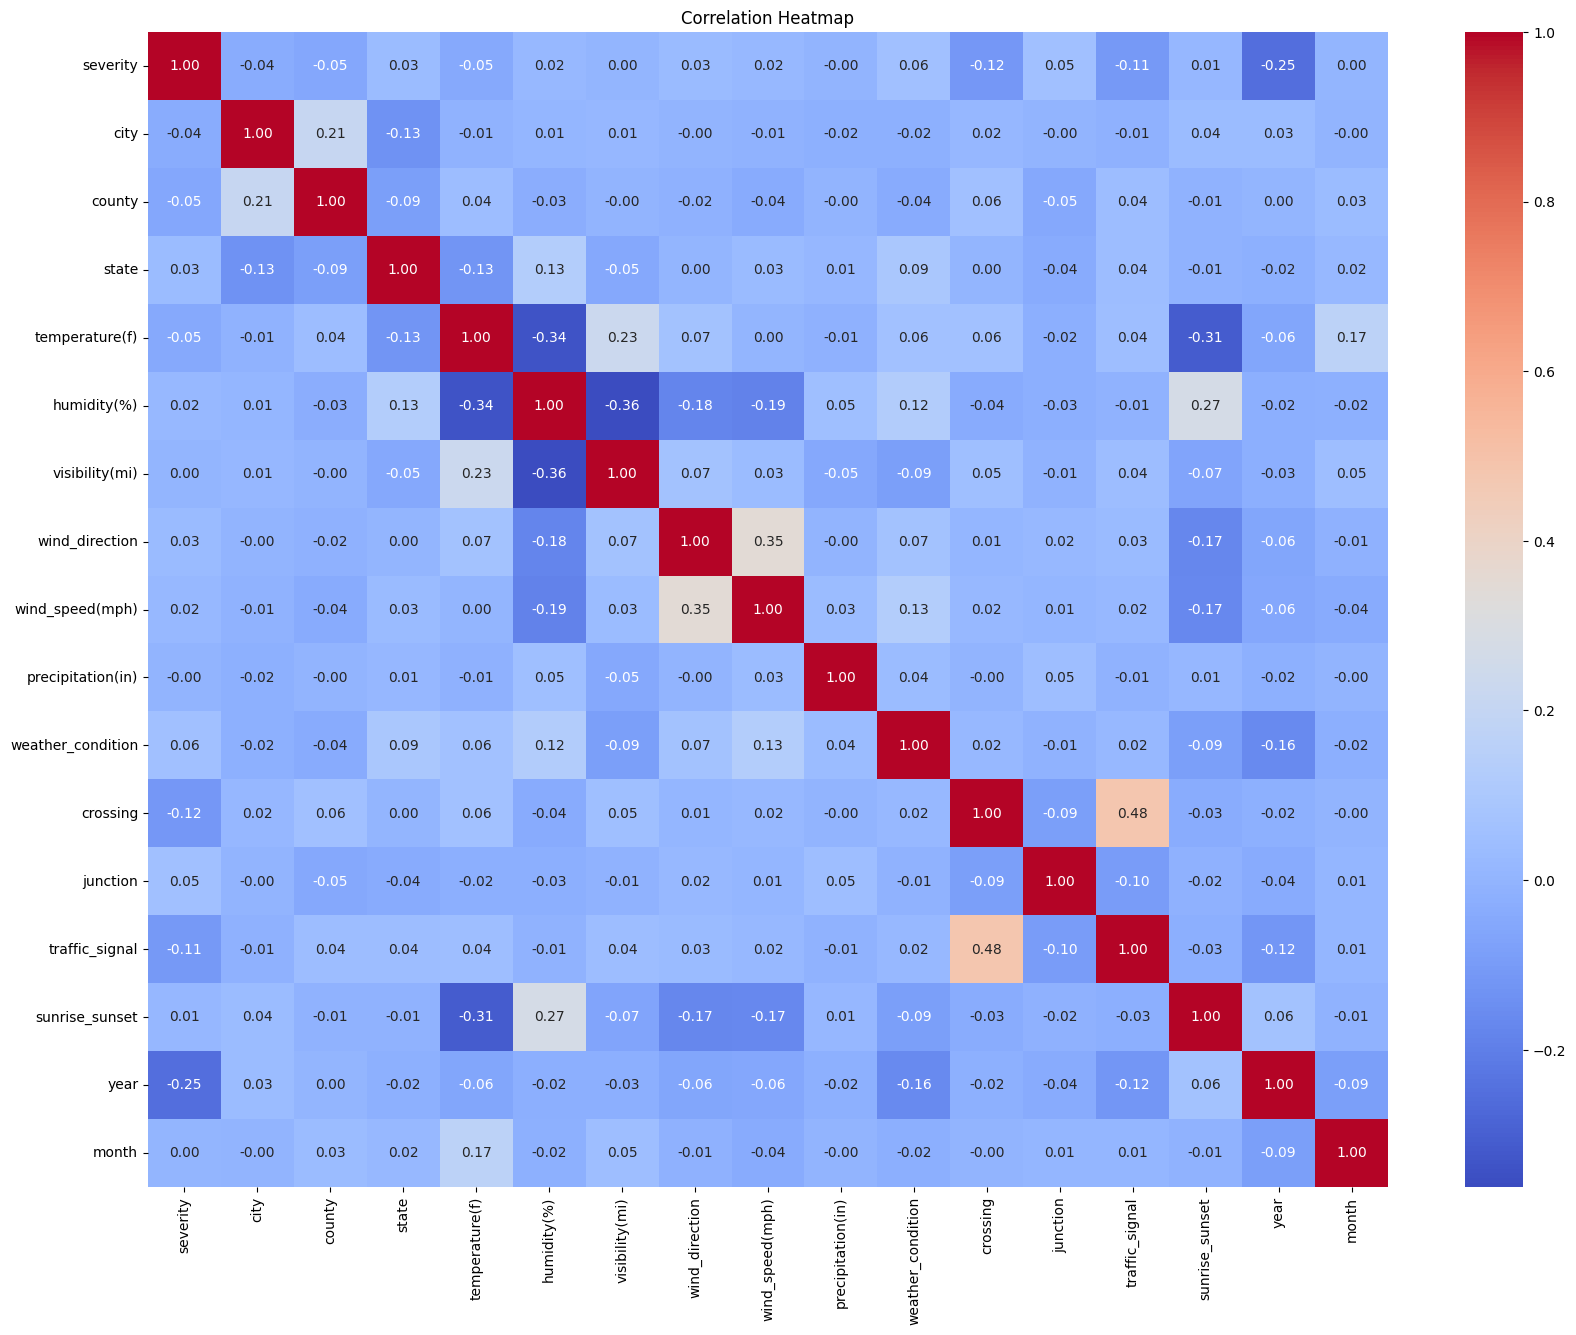

In [20]:
le = LabelEncoder()
for col in df_plots.select_dtypes(include=['object']).columns:
    df_plots[col] = le.fit_transform(df_plots[col])
    
cols_to_exclude = ['description', 'start_lat', 'start_lng', 'day', 'time' ]

corr = df_plots.drop(columns=cols_to_exclude).corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# List all strong correlations
le = LabelEncoder()
for col in df_plots.select_dtypes(include=['object']).columns:
    df_plots[col] = le.fit_transform(df_plots[col])

cols_to_exclude = ['description', 'start_lat', 'start_lng', 'day', 'time']
corr = df_plots.drop(columns=cols_to_exclude, errors='ignore').corr()


threshold = 0.25

strong_corrs = corr.stack().reset_index()
strong_corrs.columns = ['var1', 'var2', 'corr_val']

strong_corrs = strong_corrs[
    (strong_corrs['var1'] != strong_corrs['var2']) & 
    ((strong_corrs['corr_val'] > threshold) | (strong_corrs['corr_val'] < -threshold))
]

pairs = np.sort(strong_corrs[['var1', 'var2']].values, axis=1)
strong_corrs['pair_key'] = [f"{p[0]}-{p[1]}" for p in pairs]
strong_corrs = strong_corrs.drop_duplicates(subset='pair_key').drop(columns='pair_key')

strong_corrs = strong_corrs.sort_values(by='corr_val', ascending=False).reset_index(drop=True)

print(f"Found {len(strong_corrs)} strong relationships:")

strong_corrs

Found 7 strong relationships:


,var1,var2,corr_val
0,crossing,traffic_signal,0.481083
1,wind_direction,wind_speed(mph),0.347176
2,humidity(%),sunrise_sunset,0.273009
3,severity,year,-0.250464
4,temperature(f),sunrise_sunset,-0.310453
5,temperature(f),humidity(%),-0.338330
6,humidity(%),visibility(mi),-0.361923


The correlation heatmap has not provided us with any major insights due to the nature of the data. We initially set the threshold to >0.75 and <-0.75 but it returned no values. As they are all crashes there is no way to work out the correlation between these values and which of them are more likely to cause a crash, despite there being some obvious factors such as visibility, and the weather.

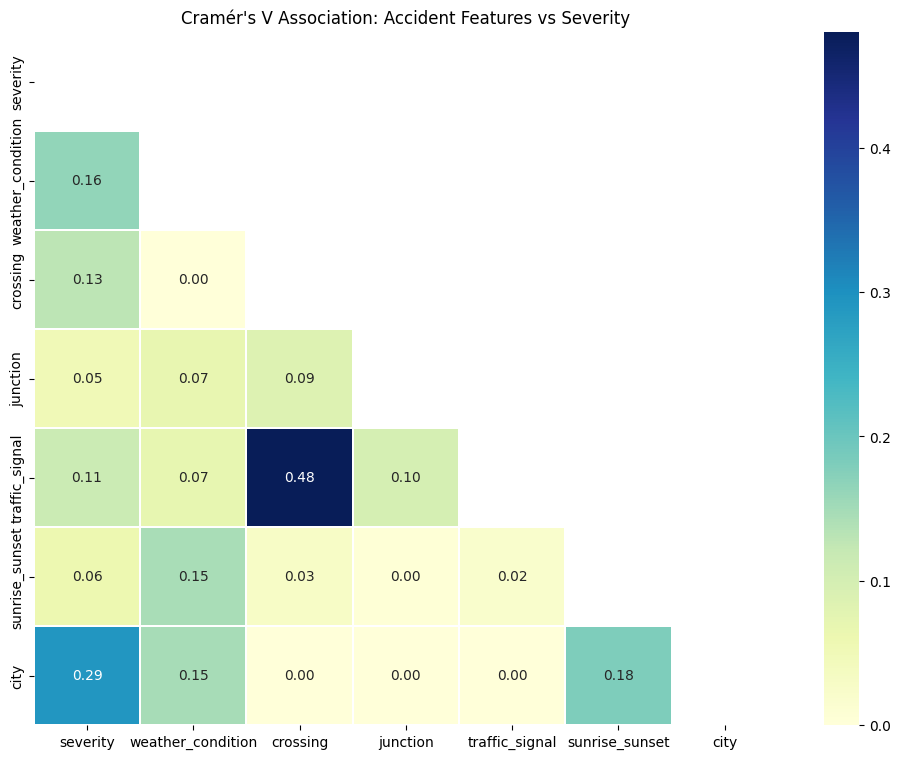

In [26]:
def cramers_v(x, y):
    """ Calculates Cramér's V statistic for categorical-categorical association. """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    if n == 0: return 0
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    # Bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0: return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# 1. Select the relevant categorical and boolean columns from df_plots
cols_to_analyse = [
    'severity', 'weather_condition', 'crossing', 
    'junction', 'traffic_signal', 'sunrise_sunset', 'city'
]

# Ensure we are only using rows with data for these columns
df_subset = df_plots[cols_to_analyse].dropna()

# 2. Calculate the Association Matrix
rows = []
for x in cols_to_analyse:
    col = []
    for y in cols_to_analyse:
        col.append(cramers_v(df_subset[x], df_subset[y]))
    rows.append(col)

cv_matrix = pd.DataFrame(rows, index=cols_to_analyse, columns=cols_to_analyse)

# 3. Visualise the Results
plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(cv_matrix, dtype=bool)) # Optional: hide top triangle

sns.heatmap(cv_matrix, 
            annot=True, 
            mask=mask,
            fmt=".2f", 
            cmap='YlGnBu', 
            linewidths=0.1)

plt.title("Cramér's V Association: Accident Features vs Severity")
plt.show()